## **Method of Label-dependent Costs**

*This method adjusts the cost (or weight) of different types of errors in the loss function to account for label noise.*

### Uncorrelated Data

##### Main method

Simulation Study: n_samples=1000, n_features=10, noise_rate_positive=0.1, noise_rate_negative=0.3
Weighted Logistic Regression - Mean accuracy: 0.8123, Standard deviation: 0.0793
Unweighted Logistic Regression - Mean accuracy: 0.7717, Standard deviation: 0.0801
SVM - Mean accuracy: 0.8946, Standard deviation: 0.0547


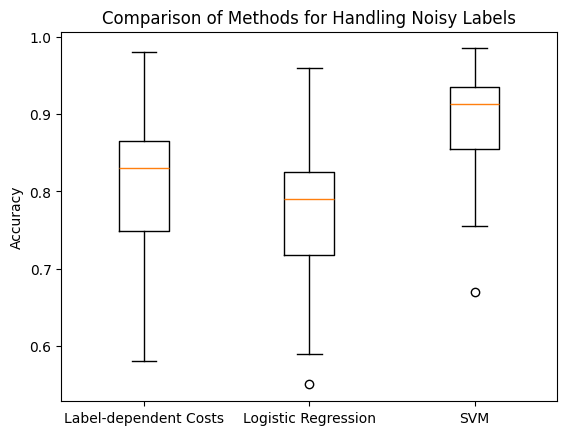

In [10]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, n_samples=1000, n_features=10, noise_rate_positive=0.1, noise_rate_negative=0.3, seed=None):
        self.n_samples = n_samples
        self.n_features = n_features
        self.noise_rate_positive = noise_rate_positive
        self.noise_rate_negative = noise_rate_negative
        self.seed = seed
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def generate_data(self, seed):
        """
        Generate a synthetic dataset with noisy labels.
        """
        np.random.seed(seed)
        self.X, self.y = make_classification(n_samples=self.n_samples, n_features=self.n_features, n_classes=2, flip_y=0, n_redundant=4, n_informative=6, random_state=seed)
        self.y = np.where(self.y == 0, -1, 1)
        
        self.y_noisy = self.y.copy()
        indices_class_1 = np.where(self.y == 1)[0]
        indices_class_minus_1 = np.where(self.y == -1)[0]
        n_flip_class_1 = int(self.noise_rate_positive * len(indices_class_1))
        flip_indices_class_1 = np.random.choice(indices_class_1, size=n_flip_class_1, replace=False)
        n_flip_class_minus_1 = int(self.noise_rate_negative * len(indices_class_minus_1))
        flip_indices_class_minus_1 = np.random.choice(indices_class_minus_1, size=n_flip_class_minus_1, replace=False)
        self.y_noisy[flip_indices_class_1] = -self.y_noisy[flip_indices_class_1]
        self.y_noisy[flip_indices_class_minus_1] = -self.y_noisy[flip_indices_class_minus_1]
    
    def get_data(self, seed):
        """
        Return the generated data.
        """
        self.generate_data(seed)
        return self.X, self.y, self.y_noisy

    def generate_multiple_datasets(self, n_datasets=100):
        """
        Generate multiple datasets for simulation.
        """
        datasets = []
        for i in range(n_datasets):
            seed_i = self.seed + i if self.seed is not None else None
            datasets.append(self.get_data(seed_i))
        return datasets

# Define the label-dependent costs
def calculate_label_dependent_costs(noise_rate_positive, noise_rate_negative):
    alpha_star = (0.5 - noise_rate_negative) / (1 - noise_rate_positive - noise_rate_negative)
    costs = {1: alpha_star, -1: 1 - alpha_star}
    return costs

# Main simulation function
def simulation_study_label_dependent_costs(n_datasets=100, n_samples=1000, n_features=10, noise_rate_positive=0.1, noise_rate_negative=0.3, test_size=0.2, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate_positive, noise_rate_negative, seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for i, (X, y, y_noisy) in enumerate(datasets):
        seed_i = seed + i if seed is not None else None
        
        # Calculate label-dependent costs
        costs = calculate_label_dependent_costs(noise_rate_positive, noise_rate_negative)
        
        # Scale the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Split data
        X_train, X_test, y_train_clean, y_test_clean = train_test_split(X_scaled, y, test_size=test_size, random_state=seed_i)
        _, _, y_train_noisy, _ = train_test_split(X_scaled, y_noisy, test_size=test_size, random_state=seed_i)
        
        # Logistic Regression with Label-Dependent Costs
        clf_weighted_lr = LogisticRegression(class_weight=costs)
        clf_weighted_lr.fit(X_train, y_train_noisy)
        y_pred_weighted_lr = clf_weighted_lr.predict(X_test)
        accuracy_weighted_lr = accuracy_score(y_test_clean, y_pred_weighted_lr)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Logistic Regression without Label-Dependent Costs
        clf_unweighted_lr = LogisticRegression()
        clf_unweighted_lr.fit(X_train, y_train_noisy)
        y_pred_unweighted_lr = clf_unweighted_lr.predict(X_test)
        accuracy_unweighted_lr = accuracy_score(y_test_clean, y_pred_unweighted_lr)
        accuracies_unweighted_lr.append(accuracy_unweighted_lr)
        
        # SVM without Label-Dependent Costs
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        y_pred_svm = clf_svm.predict(X_test)
        accuracy_svm = accuracy_score(y_test_clean, y_pred_svm)
        accuracies_svm.append(accuracy_svm)
    
    print(f"Simulation Study: n_samples={n_samples}, n_features={n_features}, noise_rate_positive={noise_rate_positive}, noise_rate_negative={noise_rate_negative}")
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study_label_dependent_costs(seed=42)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)
mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)
mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Weighted Logistic Regression - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Additional: Visualize the results (optional)
def visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename = "label_dependent_costs.jpg"):
    plt.boxplot([accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm], labels=['Label-dependent Costs', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods for Handling Noisy Labels')
    # plt.savefig(filename, format='jpg', dpi=300)
    plt.show()

# Visualize the accuracies
visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename = "label_dependent_costs.jpg")

#### Hypothesis Testing

Paired t-test results: t-statistic = 9.6076, p-value = 0.0000
Reject the null hypothesis: There is a significant difference in performance.
Accuracies with Fixed Noise Rates: [0.75, 0.855, 0.9, 0.685, 0.915, 0.715, 0.88, 0.94, 0.655, 0.81, 0.7, 0.83, 0.925, 0.79, 0.77, 0.84, 0.89, 0.895, 0.705, 0.84, 0.915, 0.865, 0.83, 0.73, 0.71, 0.745, 0.875, 0.86, 0.77, 0.89, 0.905, 0.895, 0.745, 0.845, 0.795, 0.795, 0.68, 0.655, 0.82, 0.915, 0.78, 0.79, 0.865, 0.905, 0.835, 0.7, 0.865, 0.78, 0.82, 0.755, 0.94, 0.86, 0.865, 0.73, 0.785, 0.855, 0.81, 0.86, 0.85, 0.875, 0.88, 0.73, 0.875, 0.85, 0.855, 0.795, 0.86, 0.91, 0.58, 0.85, 0.72, 0.765, 0.69, 0.725, 0.83, 0.83, 0.84, 0.835, 0.845, 0.74, 0.74, 0.77, 0.78, 0.98, 0.845, 0.755, 0.925, 0.73, 0.91, 0.835, 0.91, 0.8, 0.86, 0.735, 0.915, 0.835, 0.73, 0.635, 0.805, 0.675]
Accuracies with Estimated Noise Rates: [0.795, 0.805, 0.815, 0.635, 0.92, 0.625, 0.8, 0.86, 0.615, 0.675, 0.695, 0.8, 0.81, 0.695, 0.76, 0.805, 0.86, 0.845, 0.67, 0.81, 0.87, 0.84, 0

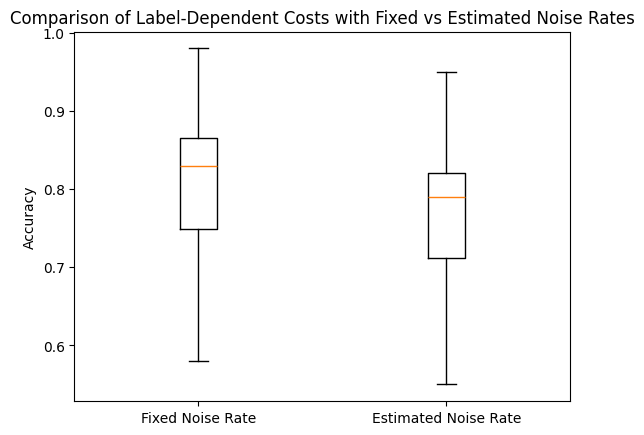

In [2]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, n_samples=1000, n_features=10, noise_rate_positive=0.1, noise_rate_negative=0.3, seed=None):
        self.n_samples = n_samples
        self.n_features = n_features
        self.noise_rate_positive = noise_rate_positive
        self.noise_rate_negative = noise_rate_negative
        # self.correlation = correlation  # Adding correlation parameter
        self.seed = seed
        self.rng = np.random.default_rng(seed)  # Consistent random generator
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def generate_data(self, seed):
        np.random.seed(seed)
        self.X, self.y = make_classification(n_samples=self.n_samples, n_features=self.n_features, n_classes=2, flip_y=0, n_redundant=4, n_informative=6, random_state=seed)
        self.y = np.where(self.y == 0, -1, 1)
        
        self.y_noisy = self.y.copy()
        indices_class_1 = np.where(self.y == 1)[0]
        indices_class_minus_1 = np.where(self.y == -1)[0]
        n_flip_class_1 = int(self.noise_rate_positive * len(indices_class_1))
        flip_indices_class_1 = np.random.choice(indices_class_1, size=n_flip_class_1, replace=False)
        n_flip_class_minus_1 = int(self.noise_rate_negative * len(indices_class_minus_1))
        flip_indices_class_minus_1 = np.random.choice(indices_class_minus_1, size=n_flip_class_minus_1, replace=False)
        self.y_noisy[flip_indices_class_1] = -self.y_noisy[flip_indices_class_1]
        self.y_noisy[flip_indices_class_minus_1] = -self.y_noisy[flip_indices_class_minus_1]
    
    def get_data(self, seed):
        self.generate_data(seed)
        return self.X, self.y, self.y_noisy

    def generate_multiple_datasets(self, n_datasets=100):
        datasets = []
        for i in range(n_datasets):
            seed_i = self.seed + i if self.seed is not None else None
            datasets.append(self.get_data(seed_i))
        return datasets

# Define the label-dependent costs
def calculate_label_dependent_costs(noise_rate_positive, noise_rate_negative):
    alpha_star = (0.5 - noise_rate_negative) / (1 - noise_rate_positive - noise_rate_negative)
    costs = {1: alpha_star, -1: 1 - alpha_star}
    return costs

# Function to estimate noise rates
def estimate_noise_rate(X_train, y_train_noisy, threshold=0.9):
    """
    Estimate the noise rates for positive and negative classes.
    This function uses a logistic regression model to estimate the probabilities of the labels
    and then estimates the noise rate based on high-confidence misclassified instances.
    
    Parameters:
    - X_train: Training features
    - y_train_noisy: Noisy training labels
    - threshold: Probability threshold for identifying high-confidence errors
    
    Returns:
    - estimated_rho_plus: Estimated noise rate for positive class
    - estimated_rho_minus: Estimated noise rate for negative class
    """
    # Train a logistic regression model on the noisy data
    model = LogisticRegression()
    model.fit(X_train, y_train_noisy)

    # Predict probabilities
    probs = model.predict_proba(X_train)
    probs_positive = probs[:, 1] # Probability of the positive class

    positive_errors = (probs_positive > threshold) & (y_train_noisy == -1)
    negative_errors = (probs_positive < (1 - threshold)) & (y_train_noisy == 1)

    # Estimate noise rates
    estimated_rho_plus = np.mean(positive_errors)
    estimated_rho_minus = np.mean(negative_errors)

    return estimated_rho_plus, estimated_rho_minus

# Main simulation function with both fixed and estimated noise rates
def simulation_study_label_dependent_costs(n_datasets=100, n_samples=1000, n_features=10, noise_rate_positive=0.1, noise_rate_negative=0.3, test_size=0.2, seed=None):
    accuracies_fixed = []
    accuracies_estimated = []
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate_positive, noise_rate_negative, seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for i, (X, y, y_noisy) in enumerate(datasets):
        seed_i = seed + i if seed is not None else None
        
        # Split data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_train, X_test, y_train_clean, y_test_clean = train_test_split(X_scaled, y, test_size=test_size, random_state=seed_i)
        _, _, y_train_noisy, _ = train_test_split(X_scaled, y_noisy, test_size=test_size, random_state=seed_i)

        # Scenario 1: Fixed Noise Rates
        costs_fixed = calculate_label_dependent_costs(noise_rate_positive, noise_rate_negative)
        clf_weighted_lr_fixed = LogisticRegression(class_weight=costs_fixed)
        clf_weighted_lr_fixed.fit(X_train, y_train_noisy)
        y_pred_fixed = clf_weighted_lr_fixed.predict(X_test)
        accuracy_fixed = accuracy_score(y_test_clean, y_pred_fixed)
        accuracies_fixed.append(accuracy_fixed)
        
        # Scenario 2: Estimated Noise Rates
        estimated_rho_plus, estimated_rho_minus = estimate_noise_rate(X_train, y_train_noisy)
        costs_estimated = calculate_label_dependent_costs(estimated_rho_plus, estimated_rho_minus)
        clf_weighted_lr_estimated = LogisticRegression(class_weight=costs_estimated)
        clf_weighted_lr_estimated.fit(X_train, y_train_noisy)
        y_pred_estimated = clf_weighted_lr_estimated.predict(X_test)
        accuracy_estimated = accuracy_score(y_test_clean, y_pred_estimated)
        accuracies_estimated.append(accuracy_estimated)
    
    return accuracies_fixed, accuracies_estimated

# Run the simulation study for both fixed and estimated noise rates
accuracies_fixed, accuracies_estimated = simulation_study_label_dependent_costs(seed=42)

# Perform a paired t-test to check if there is a significant difference
t_statistic, p_value = stats.ttest_rel(accuracies_fixed, accuracies_estimated)
print(f"Paired t-test results: t-statistic = {t_statistic:.4f}, p-value = {p_value:.4f}")

# Interpretation of the hypothesis test result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in performance.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in performance.")


## Print the accuracies for both scenarios
# print("Accuracies with Fixed Noise Rates:", accuracies_fixed)
# print("Accuracies with Estimated Noise Rates:", accuracies_estimated)
# 
## Compare them element-wise
# for i in range(len(accuracies_fixed)):
    # print(f"Dataset {i+1}: Fixed = {accuracies_fixed[i]}, Estimated = {accuracies_estimated[i]}")


# Calculate Cohen's d to measure effect size
mean_fixed = np.mean(accuracies_fixed)
mean_estimated = np.mean(accuracies_estimated)
std_pooled = np.sqrt((np.std(accuracies_fixed, ddof=1) ** 2 + np.std(accuracies_estimated, ddof=1) ** 2) / 2)
cohens_d = (mean_fixed - mean_estimated) / std_pooled
print(f"Cohen's d: {cohens_d:.4f}")


# Visualization: Compare the accuracies for fixed and estimated noise rates
def visualize_label_dependent_costs_comparison(accuracies_fixed, accuracies_estimated):
    data = [accuracies_fixed, accuracies_estimated]
    plt.boxplot(data, labels=['Fixed Noise Rate', 'Estimated Noise Rate'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Label-Dependent Costs with Fixed vs Estimated Noise Rates')
    # plt.savefig("label_dependent_costs_comparison.jpg", format='jpg', dpi=300)
    plt.show()

# Visualize the accuracies
visualize_label_dependent_costs_comparison(accuracies_fixed, accuracies_estimated)

The t-test found a statistically significant difference because the difference in accuracy between the fixed and estimated noise rate scenarios was consistent across datasets. Even though the difference in mean accuracy may seem small visually, the test detected that it was reliably present across many datasets. To understand how meaningful the difference is, we computed an effect size metric, such as Cohen’s d, which provides a standardized measure of how large the difference is. The value will show how practically meaningful the difference is, beyond just being statistically significant and the value of 0.5329 represents a medium size effect.

### Correlated Data

#### Comparison to classic models

Simulation Study: n_samples=1000, n_features=15, noise_rate_positive=0.1, noise_rate_negative=0.3
Label-dependent Costs - Mean accuracy: 0.8218, Standard deviation: 0.0243
Unweighted Logistic Regression - Mean accuracy: 0.7912, Standard deviation: 0.0243
SVM - Mean accuracy: 0.9022, Standard deviation: 0.0235


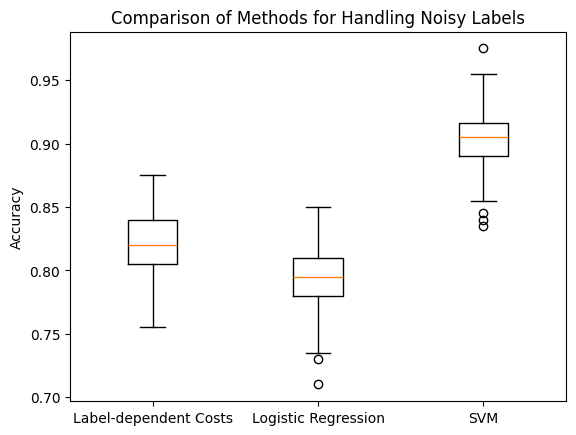

In [63]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from noisy_data_simulation import NoisyLabelSimulation

# Create a simulated dataset
def run_simulation():
    simulation = NoisyLabelSimulation(n_samples=1000, n_features=15, noise_rate_positive=0.1, noise_rate_negative=0.3, seed=42)
    X, y, y_noisy = simulation.get_data()

# Define the label-dependent costs
def calculate_label_dependent_costs(noise_rate_positive, noise_rate_negative):
    alpha_star = (0.5 - noise_rate_negative) / (1 - noise_rate_positive - noise_rate_negative)
    costs = {1: alpha_star, -1: 1 - alpha_star}
    return costs

# Main simulation function
def simulation_study_label_dependent_costs(n_datasets=100, n_samples=1000, n_features=15, noise_rate_positive=0.1, noise_rate_negative=0.3, test_size=0.2, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate_positive, noise_rate_negative, correlation=0.8, seed=seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for i, (X, y, y_noisy) in enumerate(datasets):
        seed_i = seed + i if seed is not None else None
        
        # Calculate label-dependent costs
        costs = calculate_label_dependent_costs(noise_rate_positive, noise_rate_negative)
        
        # Scale the features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Split data
        X_train, X_test, y_train_clean, y_test_clean = train_test_split(X_scaled, y, test_size=test_size, random_state=seed_i)
        _, _, y_train_noisy, _ = train_test_split(X_scaled, y_noisy, test_size=test_size, random_state=seed_i)
        
        # Logistic Regression with Label-Dependent Costs
        clf_weighted_lr = LogisticRegression(class_weight=costs)
        clf_weighted_lr.fit(X_train, y_train_noisy)
        y_pred_weighted_lr = clf_weighted_lr.predict(X_test)
        accuracy_weighted_lr = accuracy_score(y_test_clean, y_pred_weighted_lr)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Logistic Regression without Label-Dependent Costs
        clf_unweighted_lr = LogisticRegression()
        clf_unweighted_lr.fit(X_train, y_train_noisy)
        y_pred_unweighted_lr = clf_unweighted_lr.predict(X_test)
        accuracy_unweighted_lr = accuracy_score(y_test_clean, y_pred_unweighted_lr)
        accuracies_unweighted_lr.append(accuracy_unweighted_lr)
        
        # SVM without Label-Dependent Costs
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        y_pred_svm = clf_svm.predict(X_test)
        accuracy_svm = accuracy_score(y_test_clean, y_pred_svm)
        accuracies_svm.append(accuracy_svm)
    
    print(f"Simulation Study: n_samples={n_samples}, n_features={n_features}, noise_rate_positive={noise_rate_positive}, noise_rate_negative={noise_rate_negative}")
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study_label_dependent_costs(seed=42)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)
mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)
mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Label-dependent Costs - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Additional: Visualize the results (optional)
def visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename = "label_dependent_costs.jpg"):
    plt.boxplot([accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm], labels=['Label-dependent Costs', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods for Handling Noisy Labels')
    plt.show()

# Visualize the accuracies
visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm)

#### Hypothesis Testing
*Does the noise rate being fixed have an impact on the accuracy of the model?*

Paired t-test results: t-statistic = 10.4270, p-value = 0.0000
Reject the null hypothesis: There is a significant difference in performance.
Cohen's d: 1.3254


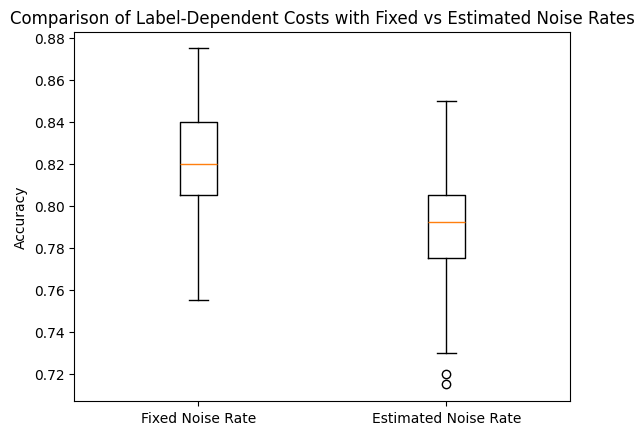

In [57]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt

from noisy_data_simulation import NoisyLabelSimulation

# Create a simulated dataset
def run_simulation():
    simulation = NoisyLabelSimulation(n_samples=1000, n_features=15, noise_rate_positive=0.1, noise_rate_negative=0.3, seed=42)
    X, y, y_noisy = simulation.get_data()

# Define the label-dependent costs
def calculate_label_dependent_costs(noise_rate_positive, noise_rate_negative):
    alpha_star = (0.5 - noise_rate_negative) / (1 - noise_rate_positive - noise_rate_negative)
    costs = {1: alpha_star, -1: 1 - alpha_star}
    return costs

# Function to estimate noise rates
def estimate_noise_rate(X_train, y_train_noisy, threshold=0.9):
    """
    Estimate the noise rates for positive and negative classes.
    This function uses a logistic regression model to estimate the probabilities of the labels
    and then estimates the noise rate based on high-confidence misclassified instances.
    """
    model = LogisticRegression()
    model.fit(X_train, y_train_noisy)

    # Predict probabilities
    probs = model.predict_proba(X_train)
    probs_positive = probs[:, 1]  # Probability of the positive class

    positive_errors = (probs_positive > threshold) & (y_train_noisy == -1)
    negative_errors = (probs_positive < (1 - threshold)) & (y_train_noisy == 1)

    # Estimate noise rates
    estimated_rho_plus = np.mean(positive_errors)
    estimated_rho_minus = np.mean(negative_errors)

    return estimated_rho_plus, estimated_rho_minus

# Main simulation function with both fixed and estimated noise rates
def simulation_study_label_dependent_costs(n_datasets=100, n_samples=1000, n_features=15, noise_rate_positive=0.1, noise_rate_negative=0.3, test_size=0.2, seed=None):
    accuracies_fixed = []
    accuracies_estimated = []
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate_positive, noise_rate_negative, correlation=0.8, seed=seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for i, (X, y, y_noisy) in enumerate(datasets):
        seed_i = seed + i if seed is not None else None
        
        # Split data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_train, X_test, y_train_clean, y_test_clean = train_test_split(X_scaled, y, test_size=test_size, random_state=seed_i)
        _, _, y_train_noisy, _ = train_test_split(X_scaled, y_noisy, test_size=test_size, random_state=seed_i)

        # Scenario 1: Fixed Noise Rates
        costs_fixed = calculate_label_dependent_costs(noise_rate_positive, noise_rate_negative)
        clf_weighted_lr_fixed = LogisticRegression(class_weight=costs_fixed)
        clf_weighted_lr_fixed.fit(X_train, y_train_noisy)
        y_pred_fixed = clf_weighted_lr_fixed.predict(X_test)
        accuracy_fixed = accuracy_score(y_test_clean, y_pred_fixed)
        accuracies_fixed.append(accuracy_fixed)
        
        # Scenario 2: Estimated Noise Rates
        estimated_rho_plus, estimated_rho_minus = estimate_noise_rate(X_train, y_train_noisy)
        costs_estimated = calculate_label_dependent_costs(estimated_rho_plus, estimated_rho_minus)
        clf_weighted_lr_estimated = LogisticRegression(class_weight=costs_estimated)
        clf_weighted_lr_estimated.fit(X_train, y_train_noisy)
        y_pred_estimated = clf_weighted_lr_estimated.predict(X_test)
        accuracy_estimated = accuracy_score(y_test_clean, y_pred_estimated)
        accuracies_estimated.append(accuracy_estimated)
    
    return accuracies_fixed, accuracies_estimated

# Run the simulation study for both fixed and estimated noise rates
accuracies_fixed, accuracies_estimated = simulation_study_label_dependent_costs(seed=42)

# Perform a paired t-test to check if there is a significant difference
t_statistic, p_value = stats.ttest_rel(accuracies_fixed, accuracies_estimated)
print(f"Paired t-test results: t-statistic = {t_statistic:.4f}, p-value = {p_value:.4f}")

# Interpretation of the hypothesis test result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in performance.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in performance.")

# Calculate Cohen's d to measure effect size
mean_fixed = np.mean(accuracies_fixed)
mean_estimated = np.mean(accuracies_estimated)
std_pooled = np.sqrt((np.std(accuracies_fixed, ddof=1) ** 2 + np.std(accuracies_estimated, ddof=1) ** 2) / 2)
cohens_d = (mean_fixed - mean_estimated) / std_pooled
print(f"Cohen's d: {cohens_d:.4f}")

# Visualization: Compare the accuracies for fixed and estimated noise rates
def visualize_label_dependent_costs_comparison(accuracies_fixed, accuracies_estimated):
    data = [accuracies_fixed, accuracies_estimated]
    plt.boxplot(data, labels=['Fixed Noise Rate', 'Estimated Noise Rate'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Label-Dependent Costs with Fixed vs Estimated Noise Rates')
    plt.show()

# Visualize the accuracies
visualize_label_dependent_costs_comparison(accuracies_fixed, accuracies_estimated)

#### Effect of Noise Rate on Accuracy

Running simulation for noise_rate_positive=0.1, noise_rate_negative=0.1, n_features=15, n_samples=1000
Simulation Study: n_samples=1000, n_features=15, noise_rate_positive=0.1, noise_rate_negative=0.1
Simulation run successful.
Running simulation for noise_rate_positive=0.1, noise_rate_negative=0.1, n_features=15, n_samples=2000
Simulation Study: n_samples=2000, n_features=15, noise_rate_positive=0.1, noise_rate_negative=0.1
Simulation run successful.
Running simulation for noise_rate_positive=0.1, noise_rate_negative=0.1, n_features=15, n_samples=3000
Simulation Study: n_samples=3000, n_features=15, noise_rate_positive=0.1, noise_rate_negative=0.1
Simulation run successful.
Running simulation for noise_rate_positive=0.1, noise_rate_negative=0.1, n_features=20, n_samples=1000
Simulation Study: n_samples=1000, n_features=20, noise_rate_positive=0.1, noise_rate_negative=0.1
Simulation run successful.
Running simulation for noise_rate_positive=0.1, noise_rate_negative=0.1, n_features=20, 

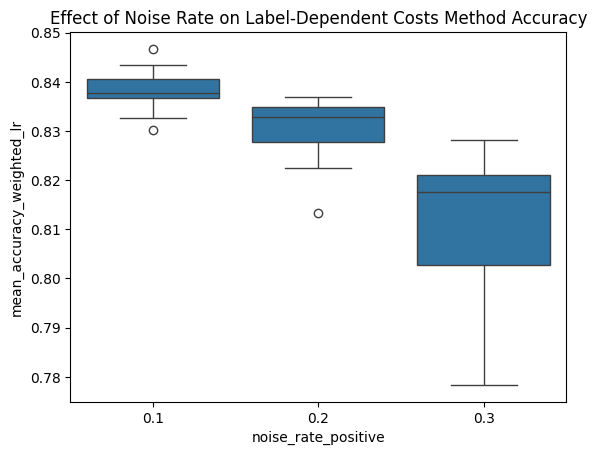

In [64]:
# Multiple Configurations for Label-Dependent Costs
def simulation_study_multiple_configs_label_dependent_costs(noise_rate_positives, noise_rate_negatives, n_features_list, n_samples_list, n_datasets=100, test_size=0.2, seed=None):
    results = []

    for noise_rate_positive, noise_rate_negative in zip(noise_rate_positives, noise_rate_negatives):
        for n_features in n_features_list:
            for n_samples in n_samples_list:
                print(f"Running simulation for noise_rate_positive={noise_rate_positive}, noise_rate_negative={noise_rate_negative}, n_features={n_features}, n_samples={n_samples}")

                accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study_label_dependent_costs(
                    n_datasets=n_datasets,
                    n_samples=n_samples,
                    n_features=n_features,
                    noise_rate_positive=noise_rate_positive,
                    noise_rate_negative=noise_rate_negative,
                    test_size=test_size,
                    seed=seed
                )
                print("Simulation run successful.")

                # Store the results with the corresponding parameters
                results.append({
                    'noise_rate_positive': noise_rate_positive,
                    'noise_rate_negative': noise_rate_negative,
                    'n_features': n_features,
                    'n_samples': n_samples,
                    'mean_accuracy_weighted_lr': np.mean(accuracies_weighted_lr),
                    'std_accuracy_weighted_lr': np.std(accuracies_weighted_lr),
                    'mean_accuracy_unweighted_lr': np.mean(accuracies_unweighted_lr),
                    'std_accuracy_unweighted_lr': np.std(accuracies_unweighted_lr),
                    'mean_accuracy_svm': np.mean(accuracies_svm),
                    'std_accuracy_svm': np.std(accuracies_svm)
                })
    
    return results

# Example usage:
noise_rate_positives = [0.1, 0.2, 0.3]
noise_rate_negatives = [0.1, 0.2, 0.3]
n_features_list = [15, 20, 30]
n_samples_list = [1000, 2000, 3000]

results_label_dependent_costs = simulation_study_multiple_configs_label_dependent_costs(
    noise_rate_positives, noise_rate_negatives, n_features_list, n_samples_list, n_datasets=100, seed=42
)

import pandas as pd
import seaborn as sns

# Convert results to DataFrame for easier analysis
df_results_label_dependent_costs = pd.DataFrame(results_label_dependent_costs)

# Example of how to visualize the effect of noise rate on accuracy
sns.boxplot(x='noise_rate_positive', y='mean_accuracy_weighted_lr', data=df_results_label_dependent_costs)
plt.title("Effect of Noise Rate on Label-Dependent Costs Method Accuracy")
plt.show()

#### UCI Benchmark Dataset

Weighted Logistic Regression - Mean accuracy: 0.9411, Standard deviation: 0.0241
Unweighted Logistic Regression - Mean accuracy: 0.8902, Standard deviation: 0.0345
SVM - Mean accuracy: 0.9325, Standard deviation: 0.0323


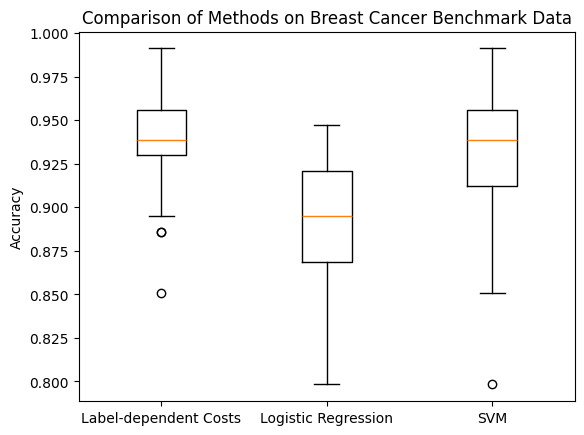

In [8]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, noise_rate_positive=0.1, noise_rate_negative=0.3, seed=None):
        self.noise_rate_positive = noise_rate_positive
        self.noise_rate_negative = noise_rate_negative
        self.seed = seed
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def load_and_preprocess_data(self):
        """
        Load and preprocess the UCI Breast Cancer dataset.
        """
        # Load dataset
        data = load_breast_cancer()
        self.X = data.data
        self.y = data.target
        
        # Standardize the features
        scaler = StandardScaler()
        self.X = scaler.fit_transform(self.X)
        
        # Convert labels from {0, 1} to {-1, 1}
        self.y = np.where(self.y == 0, -1, 1)
    
    def introduce_noise(self):
        """
        Introduce noise into the labels.
        """
        self.y_noisy = self.y.copy()
        indices_class_1 = np.where(self.y == 1)[0]
        indices_class_minus_1 = np.where(self.y == -1)[0]
        n_flip_class_1 = int(self.noise_rate_positive * len(indices_class_1))
        flip_indices_class_1 = np.random.choice(indices_class_1, size=n_flip_class_1, replace=False)
        n_flip_class_minus_1 = int(self.noise_rate_negative * len(indices_class_minus_1))
        flip_indices_class_minus_1 = np.random.choice(indices_class_minus_1, size=n_flip_class_minus_1, replace=False)
        self.y_noisy[flip_indices_class_1] = -self.y_noisy[flip_indices_class_1]
        self.y_noisy[flip_indices_class_minus_1] = -self.y_noisy[flip_indices_class_minus_1]
    
    def get_data(self):
        """
        Return the data with noisy labels.
        """
        self.load_and_preprocess_data()
        self.introduce_noise()
        return self.X, self.y, self.y_noisy

# Define the label-dependent costs
def calculate_label_dependent_costs(noise_rate_positive, noise_rate_negative):
    alpha_star = (0.5 - noise_rate_negative) / (1 - noise_rate_positive - noise_rate_negative)
    costs = {1: alpha_star, -1: 1 - alpha_star}
    return costs

# Main simulation function
def simulation_study_label_dependent_costs(n_datasets=100, noise_rate_positive=0.1, noise_rate_negative=0.3, test_size=0.2, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(noise_rate_positive, noise_rate_negative, seed)
    
    for i in range(n_datasets):
        X, y, y_noisy = simulation.get_data()
        seed_i = seed + i if seed is not None else None
        
        # Calculate label-dependent costs
        costs = calculate_label_dependent_costs(noise_rate_positive, noise_rate_negative)
        
        # Split data
        X_train, X_test, y_train_clean, y_test_clean = train_test_split(X, y, test_size=test_size, random_state=seed_i)
        _, _, y_train_noisy, _ = train_test_split(X, y_noisy, test_size=test_size, random_state=seed_i)
        
        # Logistic Regression with Label-Dependent Costs
        clf_weighted_lr = LogisticRegression(class_weight=costs)
        clf_weighted_lr.fit(X_train, y_train_noisy)
        y_pred_weighted_lr = clf_weighted_lr.predict(X_test)
        accuracy_weighted_lr = accuracy_score(y_test_clean, y_pred_weighted_lr)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Logistic Regression without Label-Dependent Costs
        clf_unweighted_lr = LogisticRegression()
        clf_unweighted_lr.fit(X_train, y_train_noisy)
        y_pred_unweighted_lr = clf_unweighted_lr.predict(X_test)
        accuracy_unweighted_lr = accuracy_score(y_test_clean, y_pred_unweighted_lr)
        accuracies_unweighted_lr.append(accuracy_unweighted_lr)
        
        # SVM without Label-Dependent Costs
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        y_pred_svm = clf_svm.predict(X_test)
        accuracy_svm = accuracy_score(y_test_clean, y_pred_svm)
        accuracies_svm.append(accuracy_svm)
    
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study_label_dependent_costs(seed=42)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)
mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)
mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Weighted Logistic Regression - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Additional: Visualize the results (optional)
def visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename = "label_dependent_costs_uci.jpg"):
    plt.boxplot([accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm], labels=['Label-dependent Costs', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods on Breast Cancer Benchmark Data')
    plt.savefig(filename, format='jpg', dpi=300)
    plt.show()

# Visualize the accuracies
visualize_results(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename = "label_dependent_costs_uci.jpg")